# **Reinforcement Learning (Policy Gradient and Deep-Q)**

=== DEMONSTRASI REINFORCEMENT LEARNING ===
Environment: CartPole-v1 (Custom Implementation)
Observation Space: Box(4,) - [position, velocity, angle, angular_velocity]
Action Space: Discrete(2) - [left, right]

1. Testing Basic Policy...
Basic Policy Average Reward: 41.35

2. Training Policy Gradient Agent...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 0, Average Score: 15.00, Loss: -0.0073
Episode 100, Average Score: 58.85, Loss: 0.0046
Episode 200, Average Score: 178.02, Loss: -0.0728
Episode 300, Average Score: 191.87, Loss: -0.0793
Episode 400, Average Score: 200.00, Loss: 0.0451
Policy Gradient Final Average Reward: 152.80

3. Training Deep Q-Network Agent...
Episode 0, Average Score: 10.00, Epsilon: 1.000, Loss: 0.0000
Episode 100, Average Score: 19.35, Epsilon: 0.609, Loss: 3.5073
Episode 200, Average Score: 12.65, Epsilon: 0.369, Loss: 1.6148
Episode 300, Average Score: 11.94, Epsilon: 0.223, Loss: 1.2893
Episode 400, Average Score: 12.23, Epsilon: 0.135, Loss: 2.1550
DQN Final Average Reward: 10.61


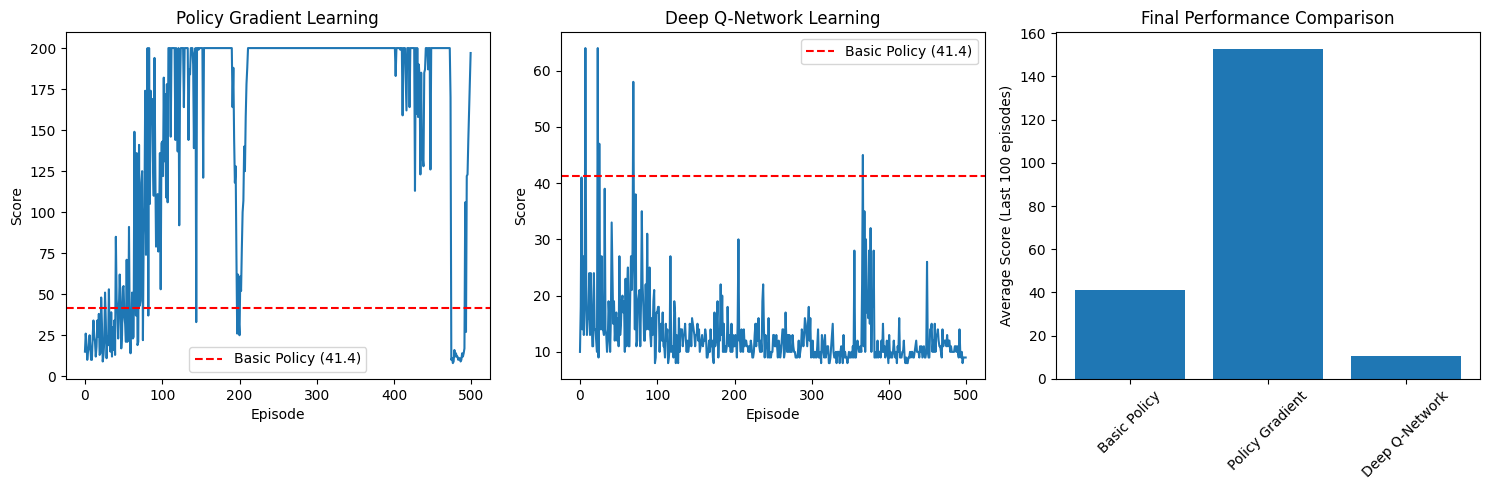


=== RINGKASAN HASIL ===
Basic Policy: 41.35
Policy Gradient: 152.80
Deep Q-Network: 10.61

Demonstrasi selesai!

=== PENJELASAN ALGORITMA ===
1. Basic Policy: Aturan sederhana berdasarkan sudut pole
2. Policy Gradient: Belajar policy optimal dengan gradient ascent
3. Deep Q-Network: Belajar Q-values dengan neural network dan experience replay


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from collections import deque
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Simple CartPole environment implementation
class SimpleCartPole:
    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * np.pi / 360
        self.x_threshold = 2.4

        self.reset()

    def reset(self):
        self.state = np.random.uniform(-0.05, 0.05, size=(4,))
        self.steps_beyond_done = None
        return self.state.copy()

    def step(self, action):
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag

        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array([x, x_dot, theta, theta_dot])

        done = (x < -self.x_threshold or x > self.x_threshold or
                theta < -self.theta_threshold_radians or theta > self.theta_threshold_radians)

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            reward = 0.0

        return self.state.copy(), reward, done, {}

# Create environment
env = SimpleCartPole()

print("=== DEMONSTRASI REINFORCEMENT LEARNING ===")
print("Environment: CartPole-v1 (Custom Implementation)")
print("Observation Space: Box(4,) - [position, velocity, angle, angular_velocity]")
print("Action Space: Discrete(2) - [left, right]")
print()

# ==========================================
# 1. BASIC POLICY (Baseline)
# ==========================================
def basic_policy(obs):
    """Policy sederhana berdasarkan sudut pole"""
    angle = obs[2]
    return 0 if angle < 0 else 1

def test_basic_policy():
    print("1. Testing Basic Policy...")
    totals = []
    for episode in range(100):
        episode_rewards = 0
        obs = env.reset()

        for step in range(200):
            action = basic_policy(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards += reward
            if done:
                break
        totals.append(episode_rewards)

    avg_reward = np.mean(totals)
    print(f"Basic Policy Average Reward: {avg_reward:.2f}")
    return avg_reward

# ==========================================
# 2. POLICY GRADIENT (REINFORCE)
# ==========================================
class PolicyGradientAgent:
    def __init__(self, state_size, action_size, lr=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr

        # Build model
        self.model = self._build_model()
        self.optimizer = keras.optimizers.Adam(learning_rate=lr)

        # Memory for episode
        self.states = []
        self.actions = []
        self.rewards = []

    def _build_model(self):
        model = keras.Sequential([
            keras.layers.Dense(24, activation='relu', input_shape=(self.state_size,)),
            keras.layers.Dense(24, activation='relu'),
            keras.layers.Dense(self.action_size, activation='softmax')
        ])
        return model

    def get_action(self, state):
        """Choose action based on policy probabilities"""
        state = np.reshape(state, [1, self.state_size])
        probabilities = self.model(state)[0]
        action = np.random.choice(self.action_size, p=probabilities.numpy())
        return action

    def remember(self, state, action, reward):
        """Store experience"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def discount_rewards(self, rewards, gamma=0.95):
        """Calculate discounted rewards"""
        discounted = np.zeros_like(rewards, dtype=np.float32)
        running_sum = 0
        for i in reversed(range(len(rewards))):
            running_sum = running_sum * gamma + rewards[i]
            discounted[i] = running_sum

        # Normalize rewards
        discounted = (discounted - np.mean(discounted)) / (np.std(discounted) + 1e-8)
        return discounted

    def train(self):
        """Train the policy network"""
        # Calculate discounted rewards
        discounted_rewards = self.discount_rewards(self.rewards)

        # Convert to tensors
        states = tf.convert_to_tensor(self.states, dtype=tf.float32)
        actions = tf.convert_to_tensor(self.actions, dtype=tf.int32)
        rewards = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32)

        with tf.GradientTape() as tape:
            # Get action probabilities
            action_probs = self.model(states)

            # Get probabilities of taken actions
            indices = tf.range(len(actions)) * self.action_size + actions
            action_probs = tf.gather(tf.reshape(action_probs, [-1]), indices)

            # Calculate loss (negative log likelihood weighted by rewards)
            loss = -tf.reduce_mean(tf.math.log(action_probs + 1e-8) * rewards)

        # Apply gradients
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        # Clear memory
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()

        return loss.numpy()

def train_policy_gradient():
    print("\n2. Training Policy Gradient Agent...")
    agent = PolicyGradientAgent(state_size=4, action_size=2)

    scores = []
    losses = []

    for episode in range(500):
        state = env.reset()
        total_reward = 0

        for step in range(200):
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)

            agent.remember(state, action, reward)
            state = next_state
            total_reward += reward

            if done:
                break

        # Train after each episode
        loss = agent.train()
        scores.append(total_reward)
        losses.append(loss)

        if episode % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print(f"Episode {episode}, Average Score: {avg_score:.2f}, Loss: {loss:.4f}")

    avg_reward = np.mean(scores[-100:])
    print(f"Policy Gradient Final Average Reward: {avg_reward:.2f}")
    return scores, agent

# ==========================================
# 3. DEEP Q-LEARNING (DQN)
# ==========================================
class DQNAgent:
    def __init__(self, state_size, action_size, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.lr = lr

        # Build networks
        self.q_network = self._build_model()
        self.target_network = self._build_model()
        self.update_target_network()

    def _build_model(self):
        model = keras.Sequential([
            keras.layers.Dense(24, activation='relu', input_shape=(self.state_size,)),
            keras.layers.Dense(24, activation='relu'),
            keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.lr),
                     loss='mse')
        return model

    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.set_weights(self.q_network.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, state):
        """Choose action using epsilon-greedy policy"""
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        state = np.reshape(state, [1, self.state_size])
        q_values = self.q_network(state)
        return np.argmax(q_values[0])

    def replay(self, batch_size=32):
        """Train the network on a batch of experiences"""
        if len(self.memory) < batch_size:
            return 0

        batch = random.sample(self.memory, batch_size)
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])

        # Current Q values
        current_q_values = self.q_network(states)

        # Next Q values from target network
        next_q_values = self.target_network(next_states)

        # Calculate target Q values
        target_q_values = current_q_values.numpy()
        for i in range(batch_size):
            if dones[i]:
                target_q_values[i][actions[i]] = rewards[i]
            else:
                target_q_values[i][actions[i]] = rewards[i] + 0.95 * np.max(next_q_values[i])

        # Train the network
        history = self.q_network.fit(states, target_q_values, epochs=1, verbose=0)
        loss = history.history['loss'][0]

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

def train_dqn():
    print("\n3. Training Deep Q-Network Agent...")
    agent = DQNAgent(state_size=4, action_size=2)

    scores = []
    losses = []

    for episode in range(500):
        state = env.reset()
        total_reward = 0

        for step in range(200):
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

        # Train the agent
        loss = agent.replay()
        scores.append(total_reward)
        losses.append(loss)

        # Update target network every 10 episodes
        if episode % 10 == 0:
            agent.update_target_network()

        if episode % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print(f"Episode {episode}, Average Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.3f}, Loss: {loss:.4f}")

    avg_reward = np.mean(scores[-100:])
    print(f"DQN Final Average Reward: {avg_reward:.2f}")
    return scores, agent

# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # Test all methods
    basic_avg = test_basic_policy()
    pg_scores, pg_agent = train_policy_gradient()
    dqn_scores, dqn_agent = train_dqn()

    # Plot results
    plt.figure(figsize=(15, 5))

    # Plot Policy Gradient results
    plt.subplot(1, 3, 1)
    plt.plot(pg_scores)
    plt.title('Policy Gradient Learning')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.axhline(y=basic_avg, color='r', linestyle='--', label=f'Basic Policy ({basic_avg:.1f})')
    plt.legend()

    # Plot DQN results
    plt.subplot(1, 3, 2)
    plt.plot(dqn_scores)
    plt.title('Deep Q-Network Learning')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.axhline(y=basic_avg, color='r', linestyle='--', label=f'Basic Policy ({basic_avg:.1f})')
    plt.legend()

    # Compare final performance
    plt.subplot(1, 3, 3)
    methods = ['Basic Policy', 'Policy Gradient', 'Deep Q-Network']
    final_scores = [basic_avg, np.mean(pg_scores[-100:]), np.mean(dqn_scores[-100:])]
    plt.bar(methods, final_scores)
    plt.title('Final Performance Comparison')
    plt.ylabel('Average Score (Last 100 episodes)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("\n=== RINGKASAN HASIL ===")
    print(f"Basic Policy: {basic_avg:.2f}")
    print(f"Policy Gradient: {np.mean(pg_scores[-100:]):.2f}")
    print(f"Deep Q-Network: {np.mean(dqn_scores[-100:]):.2f}")
    print("\nDemonstrasi selesai!")

    print("\n=== PENJELASAN ALGORITMA ===")
    print("1. Basic Policy: Aturan sederhana berdasarkan sudut pole")
    print("2. Policy Gradient: Belajar policy optimal dengan gradient ascent")
    print("3. Deep Q-Network: Belajar Q-values dengan neural network dan experience replay")